In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.4.0


In [7]:
def plot_series(time, series, format="-", start=0, end=None):
  plt.plot(time[start:end], series[start:end], format)
  plt.xlabel("Time")
  plt.ylabel("Value")
  plt.grid(True)

def trend(time, slope=0):
  return slope*time

def seasonal_pattern(season_time):
  """임의의 패턴이나, 원할때 바꿀 수 있다"""
  # np.where(condition, [x, y])
  # condition을 만족하면 x를, 아닌경우 y를 반환
  return np.where(season_time<0.4, np.cos(season_time*2*np.pi), 1/np.exp(3*season_time))

def seasonality(time, period, amplitude=1, phase=0):
  """각 주기마다 같은 패턴을 반복한다"""
  season_time = ((time+phase) % period) / period
  return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

In [9]:
time = np.arange(4*365+1, dtype="float32")
baseline=10
series = trend(time, 0.1)
amplitude=40
slope=0.05
noise_level=5

# Create the series
series = baseline + trend(time, slope)+seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series+=noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [30]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  # print("Step1: ", list(dataset.as_numpy_iterator()))
  dataset = dataset.window(window_size+1, shift=1, drop_remainder=True)
  # print("Step2")
  # for window in dataset:
  #   print(list(window.as_numpy_iterator()))
  dataset = dataset.flat_map(lambda window : window.batch(window_size+1))
  # print("Step3: ", list(dataset.as_numpy_iterator()))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window:(window[:-1], window[-1]))
  # print("Step4: ", list(dataset.as_numpy_iterator()))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [33]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(dataset)
l0 = tf.keras.layers.Dense(1, input_shape=[window_size])
# 모델 생성
model = tf.keras.models.Sequential([l0])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(dataset, epochs=100, verbose=0)

print("Layer weights {}".format(l0.get_weights()))

<PrefetchDataset shapes: ((None, None), (None,)), types: (tf.float32, tf.float32)>
Layer weights [array([[-7.15078264e-02],
       [-2.02150457e-03],
       [ 1.06930763e-01],
       [-8.16584304e-02],
       [ 4.76660840e-02],
       [ 5.95840923e-02],
       [-4.85958904e-02],
       [-3.90372649e-02],
       [ 8.36492553e-02],
       [-9.57013369e-02],
       [ 4.87433523e-02],
       [-1.44318035e-02],
       [ 3.38389501e-02],
       [-4.35164757e-02],
       [-1.08399341e-04],
       [ 1.00110568e-01],
       [ 1.17676720e-01],
       [ 9.44534317e-02],
       [ 2.25424126e-01],
       [ 4.86575216e-01]], dtype=float32), array([0.01634545], dtype=float32)]


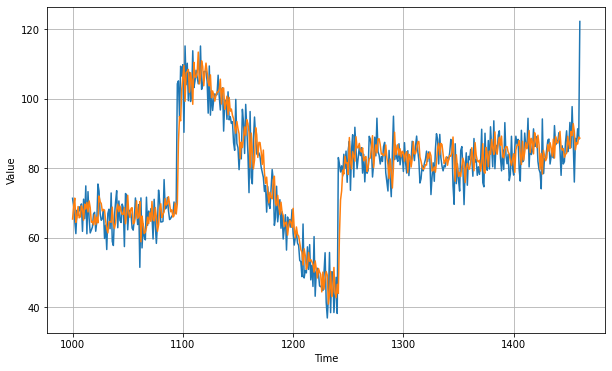

In [34]:
forecast=[]

for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time+window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

plt.figure(figsize=(10,6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [35]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

5.1499887